In [6]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pims
import trackpy as tp
from scipy.interpolate import griddata

from utils.utils import extract_frames_from_video, get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, autocorr_with_interpolation, transform_points_to_original_space
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack
from utils.utils import argnotnan, set_spines_visible, generate_video_with_text, create_scalarmappable

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

In [7]:
@pims.pipeline
def crop(img, bbox):
    """
    Crop the image to select the region of interest
    """
    xmin, xmax, ymin, ymax = bbox
    return img[ymin:ymax, xmin:xmax]


xmin, xmax = 50, 1800
ymin, ymax = 40, 1040
bbox = [xmin, xmax, ymin, ymax]

In [8]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0408_074105_019.MP4"
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename); print("vid properties: ", vid_props)
fps = vid_props[0]

# Scale D-mid
pixel_per_real_width = .75
mpp = 1.333  # microns_per_pixel
print("D MID - FHD, pixel_per_real_width = ", pixel_per_real_width)

# PIMs load in
EXPORT_FRAMES = False
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
extract_frames_from_video(vid_path, vid_filename, frames_filepaths) if EXPORT_FRAMES else None

img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(crop(pims.open(img_seq_folder), bbox))
img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))

# Save figures
results_path = "./data/results/vortex/"
save_figure_path = os.path.join(results_path, vid_filename.split(".MP4")[0])
os.makedirs(save_figure_path, exist_ok=True)
fig_params = {"dpi" : 600, "bbox_inches" : "tight", "edgecolor" : None}

# AX params
xy_real_step = 300
xy_px_step = xy_real_step * mpp 
ax_params = {
    "xticks" : np.arange(0,img_width, xy_px_step, dtype=int),
    "xticklabels" : np.arange(0, (img_width / mpp), xy_real_step, dtype=int),
    "yticks" : np.arange(0, img_height, xy_px_step, dtype=int),
    "yticklabels" : np.arange(0, (img_height / mpp), xy_real_step, dtype=int),
    "xlabel" : "X (µm)", "ylabel" : "Y (µm)",
}

# Time vector
time = np.linspace(0, len(frames) / fps, len(frames))  # in seconds
num_frames = len(time) # time_idx
print("selected time num_frames=", num_frames)#, "trigger time start-end", np.round(ttime[0]), np.round(ttime[-1]),"\n all frames", frames)

vid properties:  (60, 3311, 1920, 1080)
D MID - FHD, pixel_per_real_width =  0.75


real width (µm):  1312.83 
real height (µm): 750.19
selected time num_frames= 3311


# Z Projection over time

In [9]:
# subtract_frame_idx = 0
# subtract_frame = np.median(np.stack(frames[::3]), axis=0)
# plt.imshow(subtract_frame)
# process_frames = np.arange(0, num_frames, 3) #np.arange(subtract_frame_idx + 1, 2400)#num_frames)

# zproj = []
# for nth in process_frames:
#     zproj.append(frames[nth] - subtract_frame)
# zproj = np.stack(zproj)
# zproj = np.min(zproj, axis=0)

# SAVE_NPY = False
# if SAVE_NPY:
#     np.save(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy", zproj)
# else:
#     zproj = np.load(f"./data/results/vortex/{vid_filename.split('.')[0]}_zmin-proj_num_process_frames{process_frames[-1]}.npy")
 

In [10]:
# SAVE_FIGURES = False
# vmin_ = np.percentile(zproj, 1)#-70 #np.min(zproj)
# vmax_ = 0
# print(np.min(zproj), np.max(zproj), np.percentile(zproj, [1,5,95]))

# # R and D bbox
# #rotifer_bbox = [835, 910, 50, 510]
# rotifer_bbox = [835-xmin, 910-xmin, 50-ymin, 510-ymin]

# detritus_bbox = [625, 770, 760, 1050]
# point_count_bbox = [100, img_width-100, 520, 570]

# fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# cax = ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
# #plot_bbox(detritus_bbox, "blue", ax=ax)
# plot_bbox(rotifer_bbox, "blue", ax=ax)
# #plot_bbox(point_count_bbox, "m", ax=ax)
# ax.set(**ax_params); ax.invert_yaxis();
# cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[vmax_, vmin_], yticklabels=["max", "min"])
# fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-zmin-proj-prctile-scale_num_process_frames{process_frames[-1]}.jpg", **fig_params) if SAVE_FIGURES else None


# fig, ax = plt.subplots(1, 1, figsize=(2, 2))
# ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
# plot_bbox(rotifer_bbox, "blue", ax=ax)
# plot_bbox(point_count_bbox, "m", ax=ax)
# ax.set(**ax_params); ax.invert_yaxis();
# ax.set(xlim=(550,1200), ylim=(150, 750), xticks=[], yticks=[]);
# fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-zmin-proj-prctile-zoomin.jpg", **fig_params) if SAVE_FIGURES else None

# fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
# ax.set(xlim=(810,940), ylim=(140, 520)); ax.invert_yaxis();


# Locate features
- on feature level exclude around rot (tight) and the obsticle

n features -  240


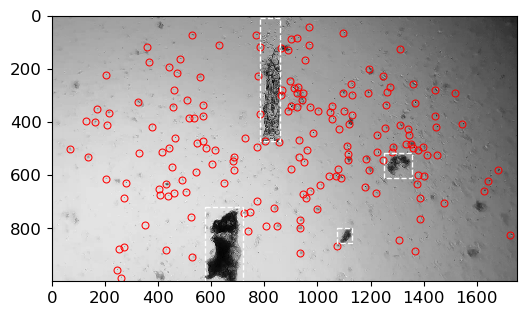

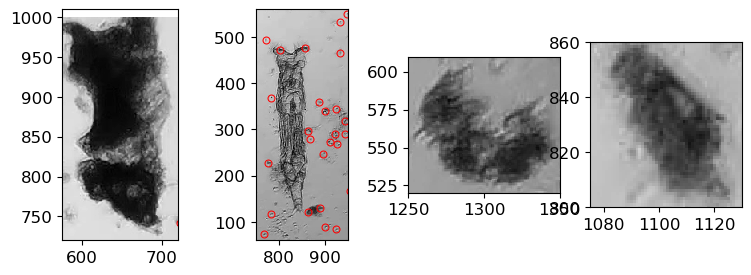

In [11]:
locate_params = {
    "diameter" : 15,
    "threshold" : 15,
    "invert" : True,
}
frame_nr = 1
# Location of features
f = tp.locate(frames[frame_nr], **locate_params)
print("n features - ", len(f))

# Rotifer exclude
rotifer_bbox = [835-xmin, 910-xmin, 50-ymin, 510-ymin]
rotifer_condition = (f.x > rotifer_bbox[0]) & (f.x < rotifer_bbox[1]) & (f.y > rotifer_bbox[2]) & (f.y < rotifer_bbox[3])
f = f[~rotifer_condition]

# Detritus exclude
detritus_bbox = {"0" : [625-xmin, 770-xmin, 760-ymin, 1050-ymin],
                 "1" :[1250, 1355, 515, 610],
                 "2" : [1075, 1130, 800, 855]}

for k, dbox in detritus_bbox.items():
    detritus_condition = (f.x > dbox[0]) & (f.x < dbox[1]) & (f.y > dbox[2]) & (f.y < dbox[3])
    f = f[~detritus_condition]

#print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))

fig, ax = plt.subplots(figsize=(6,6))
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});

# BBoxes to exclude
plot_bbox(rotifer_bbox)
for k, dbox in detritus_bbox.items(): plot_bbox(dbox)

fig, ax = plt.subplots(1,4,figsize=(9,3))
tp.annotate(f, frames[frame_nr], ax=ax[0], plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax[0].set(xlim=(625-xmin,770-xmin), ylim=(760-ymin, 1050-ymin));

tp.annotate(f, frames[frame_nr], ax=ax[1], plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax[1].set(xlim=(800-xmin,1000-xmin), ylim=(100-ymin, 600-ymin));

tp.annotate(f, frames[frame_nr], ax=ax[2], plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax[2].set(xlim=(1250,1350), ylim=(520, 610));

tp.annotate(f, frames[frame_nr], ax=ax[3], plot_style={"markersize" : 5, "markeredgewidth" : .75}); 
ax[3].set(xlim=(1075,1130), ylim=(800, 860));

# 2. Batch Process frames

In [12]:
tp.quiet()
fbatch = tp.batch(frames, **locate_params)  # fbatch = tp.batch(frames[:3000], **locate_params)  # :3000 takes ca. 10min
fbatch_ori = fbatch.copy()

rotifer_condition = (fbatch.x > rotifer_bbox[0]) & (fbatch.x < rotifer_bbox[1]) & (fbatch.y > rotifer_bbox[2]) & (fbatch.y < rotifer_bbox[3])
fbatch = fbatch[~rotifer_condition]

# tmp = []
# for k, dbox in detritus_bbox.items():
#     detritus_condition = (fbatch.x > dbox[0]) & (fbatch.x < dbox[1]) & (fbatch.y > dbox[2]) & (fbatch.y < dbox[3])
#     tmp.append(detritus_condition)

# detritus_idx = pd.DataFrame(tmp).any().to_numpy(); del tmp
# fbatch = fbatch[~detritus_idx]
    
detritus_condition = (fbatch.x > detritus_bbox["0"][0]) & (fbatch.x < detritus_bbox["0"][1]) & (fbatch.y > detritus_bbox["0"][2]) & (fbatch.y < detritus_bbox["0"][3])
fbatch = fbatch[~detritus_condition]
#print("rotifer", sum(rotifer_condition), "\ndetritus", sum(detritus_condition))

SAVE_FBATCH = False
fbatch.to_csv(f"{save_figure_path}/fbatch_3000_frames.csv", index=False) if SAVE_FBATCH else None

fbatch

# only one detritus condition[0]: df-654707 rows 

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
1,44.174020,967.662990,283.054418,1.529530,0.449688,29.831716,-17078.5358,0.502264,0
4,73.884312,529.522573,614.672093,2.661807,0.645701,31.566118,-17646.7584,0.625722,0
5,73.146641,768.789972,366.652597,2.039116,0.689823,29.484835,-17418.0000,0.569378,0
6,89.210938,900.889844,444.006930,2.061363,0.647872,36.075563,-17092.0628,0.504634,0
9,108.994390,628.847125,247.325735,1.183690,0.272373,35.728683,-18698.4176,1.147964,0
...,...,...,...,...,...,...,...,...,...
840662,943.885036,314.618613,191.536439,1.186912,0.298892,28.660562,-25585.3770,-0.258100,3310
840663,943.212943,1078.160402,1636.448190,2.912361,0.147960,42.990843,-17040.8936,0.491038,3310
840664,946.651861,497.779112,291.149368,1.335632,0.122944,35.650943,-25297.0520,-0.272108,3310
840665,957.821958,464.370920,235.575839,1.364014,0.264615,27.612005,-24905.4708,-0.293762,3310


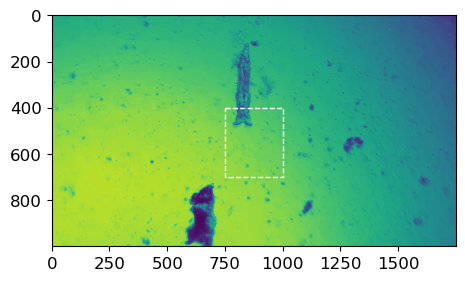

In [13]:
zoom_in = [750, 1000, 400, 700] 

plt.figure()
plt.imshow(frames[0])
plot_bbox(zoom_in)

# Read-in
img_fp = sorted([os.path.join(frames_filepaths, f) for f in os.listdir(frames_filepaths) if f.endswith(".jpg")])
cut_width, cut_height = zoom_in[1] - zoom_in[0], zoom_in[3] - zoom_in[2]
text_params = dict(org=(50, 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
video_save_fpath = f"./data/results/whirling/{vid_filename.split('.')[0]}_focus-corona-zoom-text.mp4"
vid_params = dict(filename=video_save_fpath, 
                  fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                  fps=fps, 
                  frameSize=(cut_width, cut_height), 
                  isColor=True)

SAVE_VIDEO = False
generate_video_with_text(vid_params, img_fp, text_params, bbox=zoom_in) if SAVE_VIDEO else None

# 3. Link particles / frames to trajectories

In [14]:
link_params = {
    "search_range" : 40,  # 40, within ± N pixels
    "memory" : 2,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(fps/2); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

number of obtained trajectories: 16991
30
N Before: 16991 
 N after filtering: 2486


# 4. Visualize Trajectories

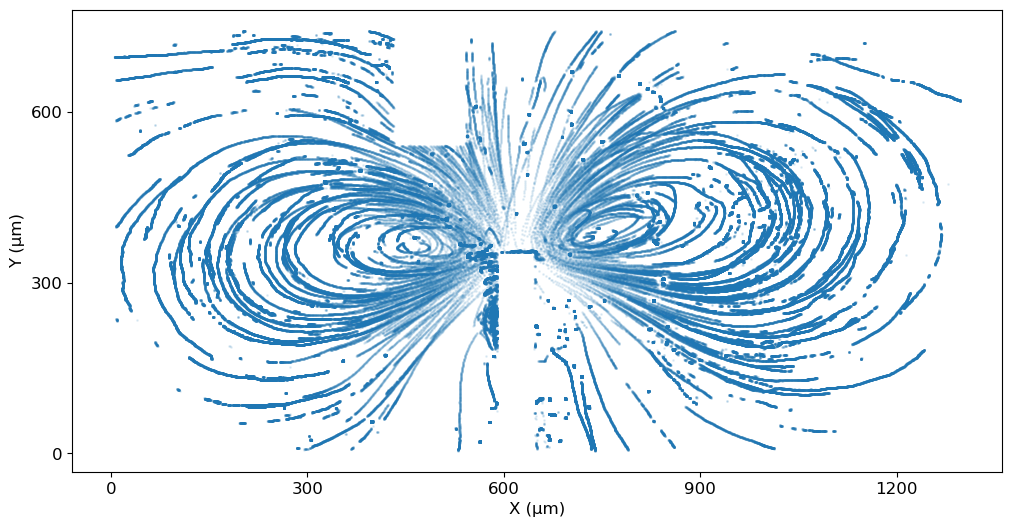

In [15]:
#SAVE_TRAJS = False
#LOAD_TRAJS = True
#trajs.to_csv(f"{save_figure_path}/trajs_3000_frames.csv", index=False) if SAVE_TRAJS else None
#trajs = pd.read_csv(f"{save_figure_path}/trajs_3000_frames.csv") if LOAD_TRAJS else None

#fig, ax = plt.subplots()
#tp.plot_traj(trajs, superimpose=frames[frame_nr], label=False, ax=ax); #ax.set(**ax_params); 

fig, ax = plt.subplots(figsize=(12,6))
tp.scatter(trajs, ax=ax, plot_style={"ms" : 1, "alpha" : .1});#, "color" : "k"
ax.set(**ax_params); ax.invert_yaxis();

### further filtering

number of particles = number of trajectories: 2486
number of particles (original): 2486 
number of particles remaining: 995
number of particles = number of trajectories: 995


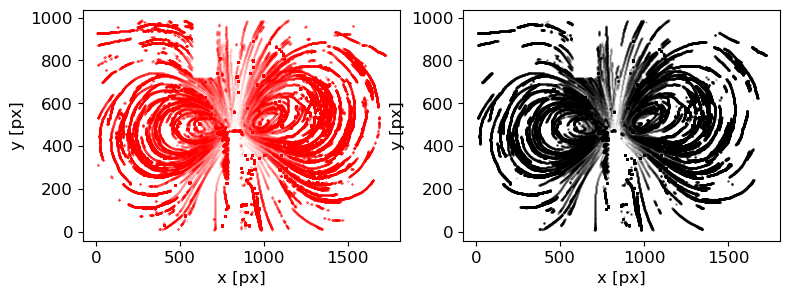

In [16]:
stats, frames_present = get_trajectory_stats(trajs);
reject_idx = (stats.x_std <= 3.5) | (stats.y_std <= 3)
reject_prts = stats.particle[reject_idx].to_numpy()

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
num_particles = ctraj.particle.nunique()
print("number of particles (original):", num_ori_particles, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj);

fig, ax = plt.subplots(1,2,figsize=(9,3))
tp.scatter(trajs, ax=ax[0], plot_style={"ms" : .25, "alpha" : .1, "color" : "r"}); ax[0].invert_yaxis(); 
tp.scatter(ctraj, ax=ax[1], plot_style={"ms" : .5, "alpha" : .1, "color" : "k"}); ax[1].invert_yaxis();

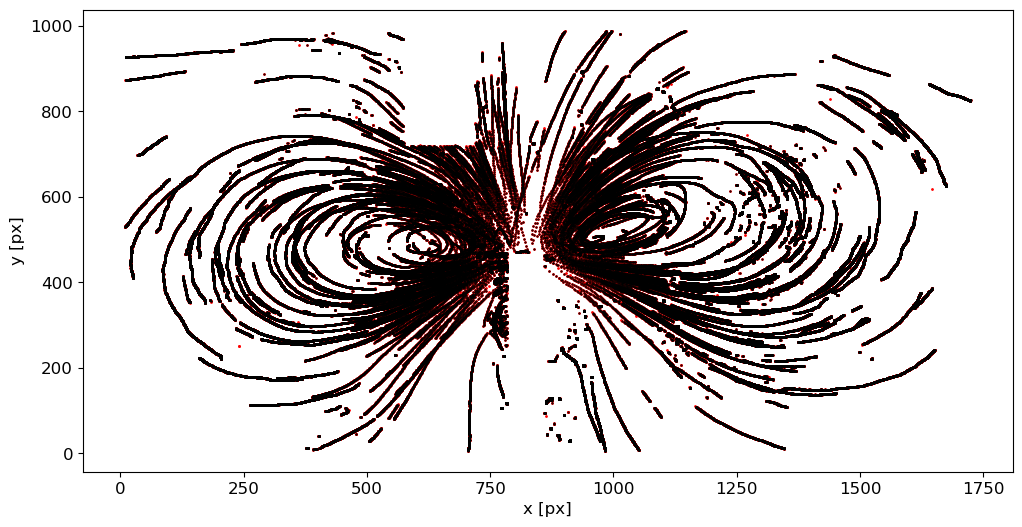

In [17]:
# check for velocit jumps!
df = ctraj[["x", "y", "particle", "frame"]].copy()
df["dx"] = df.groupby(by="particle")["x"].transform(lambda x: x.diff())
df["dy"] = df.groupby(by="particle")["y"].transform(lambda y: y.diff())
df["v"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)# * fps / mpp
df["v"] = df["v"].mask(df["v"]>=34)
df = df.dropna(subset="v")

fig, ax = plt.subplots(figsize=(6*2,3*2))
tp.scatter(ctraj, ax=ax, plot_style={"ms" : 1, "alpha" : 1, "color" : "r"});
tp.scatter(df, ax=ax, plot_style={"ms" : .5, "alpha" : 1, "color" : "k"}); ax.invert_yaxis();

In [18]:
# loop acrss trajectories and remove the ones that have any over a threshold (adjust for maybe less than 10% under trheshold or something)
particles = df.particle.unique()
keep_parts = []
for prt in particles:
    acc = df.groupby("particle").get_group(prt)["v"].diff().diff()
    #if not np.any((acc <= -7.5) | (acc > 7.5)):
    if not np.any((acc <= -11.5) | (acc > 11.5)):
        keep_parts.append(prt)

print(len(keep_parts)) # 585

424


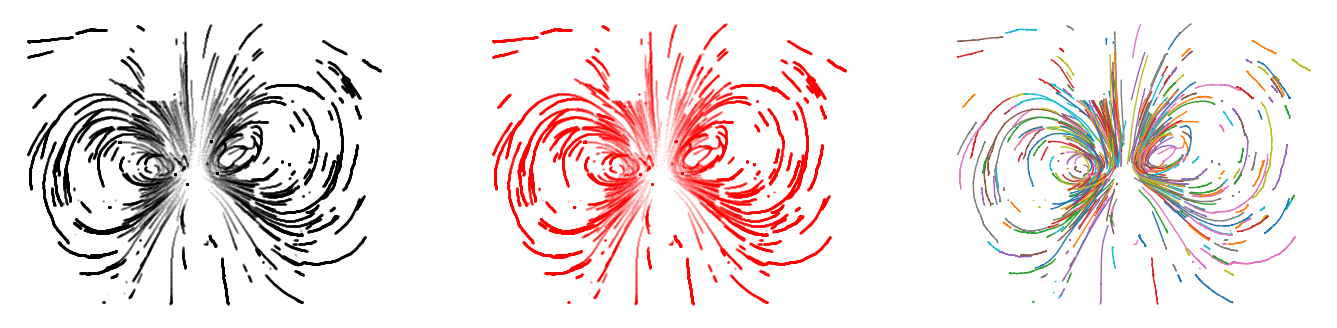

In [19]:
keeptrajs = ctraj[ctraj.particle.isin(keep_parts)]
keeptrajs_ = df[df.particle.isin(keep_parts)]

fig, ax = plt.subplots(1,3,figsize=(17,4))
tp.scatter(keeptrajs, ax=ax[0], plot_style={"ms" : .5, "alpha" : .1, "color" : "k"}); ax[0].invert_yaxis();ax[0].set_axis_off()
tp.scatter(keeptrajs_, ax=ax[1], plot_style={"ms" : .5, "alpha" : .1, "color" : "r"}); ax[1].invert_yaxis();ax[1].set_axis_off()
tp.plot_traj(keeptrajs_, ax=ax[2]); ax[2].invert_yaxis();ax[2].set_axis_off()

[(0.0, 1220000.0)]

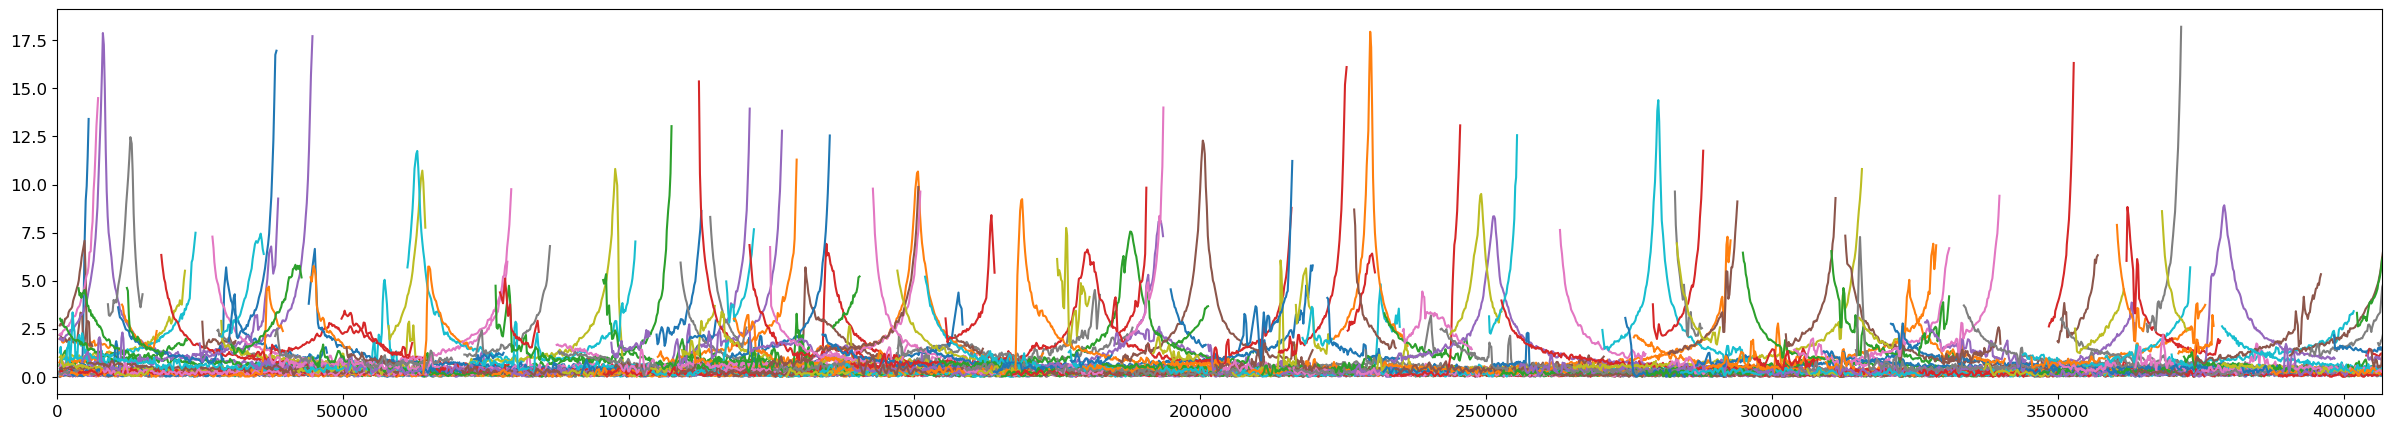

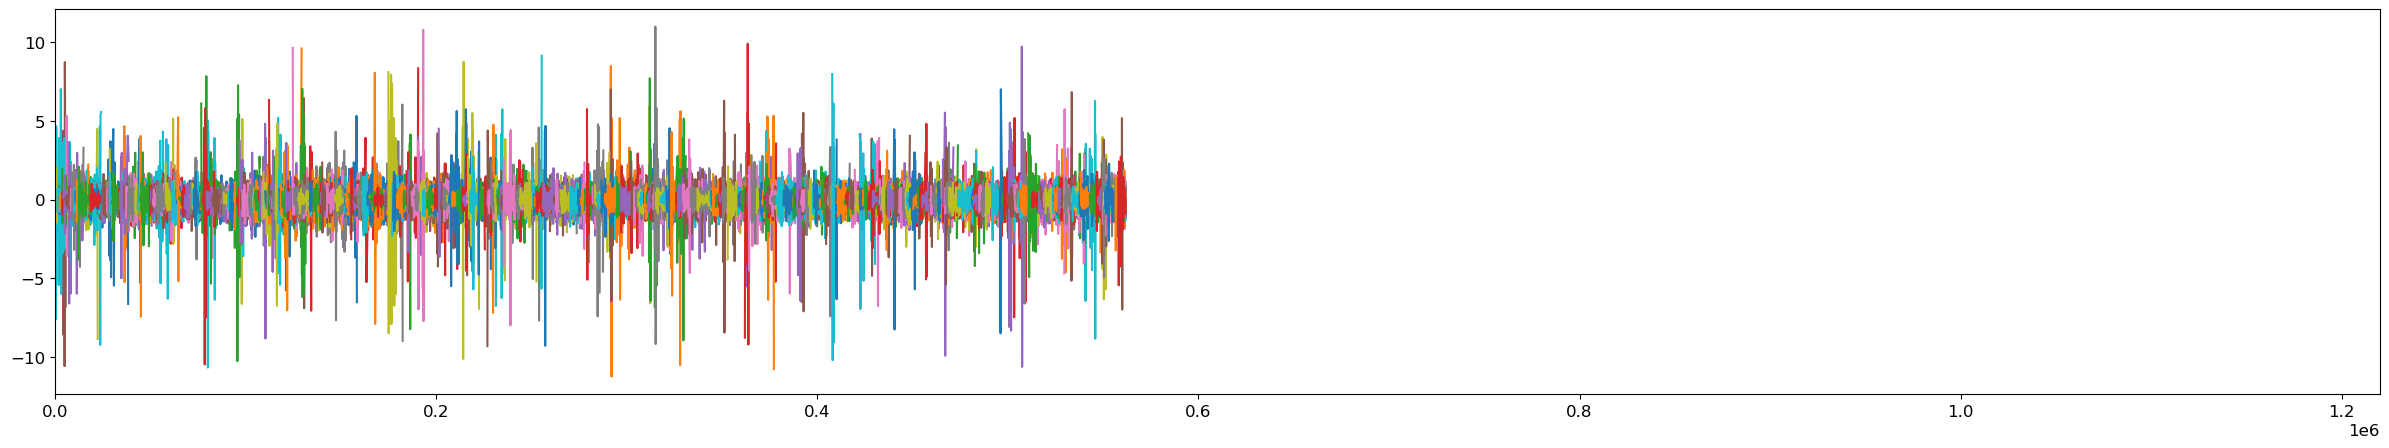

In [20]:
fig,ax = plt.subplots(figsize=(30,5))
for prt in keep_parts:
    plt.plot(df.groupby("particle").get_group(prt)["v"].rolling(window=3).mean())
ax.set(xlim=(0, 1220000/3))

fig,ax = plt.subplots(figsize=(30,5))
for prt in keep_parts:
    plt.plot(df.groupby("particle").get_group(prt)["v"].diff().diff())#.rolling(window=2).mean())

ax.set(xlim=(0, 1220000))

In [21]:

# fig,ax = plt.subplots(figsize=(30,5))
# show_prts = 35
# particles = df.particle.unique()
# # keep_parts = []
# for prt in particles[:show_prts]:
#     plt.plot(df.groupby("particle").get_group(prt)["v"].diff().diff(), "-", color="lightgrey")
#     # if not np.any(df.groupby("particle").get_group(prt)["v"].diff().diff()>=15):
#     #     keep_parts.append(prt)
# for prt in particles[:show_prts]:
#     plt.plot(df.groupby("particle").get_group(prt)["v"].diff().diff().rolling(window=3).mean())
# ax.set(xlim=(0, 1220000/3))

# fig,ax = plt.subplots(figsize=(30,5))
# #plt.hlines(10, xmin=0, xmax=30000)
# particles = df.particle.unique()
# for prt in particles[:show_prts]:
#     plt.plot(df.groupby("particle").get_group(prt)["v"], "-", color="lightgrey")
# for prt in particles[:show_prts]:
#     plt.plot(df.groupby("particle").get_group(prt)["v"].rolling(window=4).mean())

# ax.set(xlim=(0, 1220000/3))


In [22]:
points = keeptrajs_[["x", "y"]].where(keeptrajs_["v"].notna()).to_numpy()
v_xy = keeptrajs_["v"].where(keeptrajs_["v"].notna()).to_numpy()
dxy = keeptrajs_[["dx", "dy"]].where(keeptrajs_["v"].notna()).to_numpy()
print(v_xy.shape, points.shape, sum(np.isnan(dxy)), sum(np.isnan(points)))
points

(147225,) (147225, 2) [0 0] [0 0]


array([[ 899.81535948,  575.99509804],
       [ 948.35729387,  548.81818182],
       [ 542.45914397,  587.45914397],
       ...,
       [ 472.49628055,  357.54835282],
       [1290.80276021,  375.87751581],
       [1623.54885057,  375.90804598]])

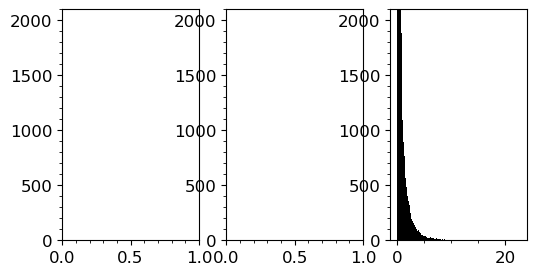

In [23]:
# check and remove rapid velocity changes
#d_xy = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2)
d_xy = argnotnan(keeptrajs_.v.to_numpy())
#cx, xbins_ = np.histogram(velocities[:,0], bins=300)
#cy, ybins_ = np.histogram(velocities[:,1], bins=300)
cxy, xybins_ = np.histogram(d_xy, bins=300)

fig, ax = plt.subplots(1,3)
#ax[0].bar(xbins_[:-1], cx, width=np.diff(xbins_[:2]), color="b")
#ax[1].bar(ybins_[:-1], cy, width=np.diff(ybins_[:2]), color="r")
ax[2].bar(xybins_[:-1], cxy, width=np.diff(xybins_[:2]), color="k")
for cax in ax:
    cax.set(ylim=(0, 2100))
    cax.minorticks_on()

percentiles vmap: 2.1982271646041243 
omap 152.28748689062712


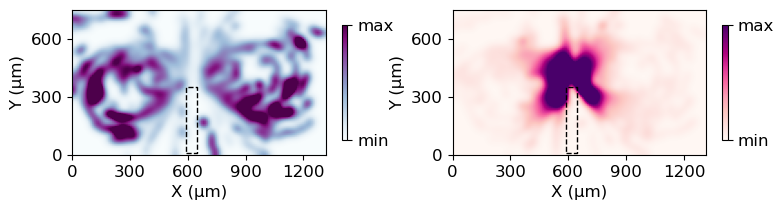

In [24]:
SAVE_FIGURES = False
bin_size_2d = 25
sigma_2d = 2

cmap = plt.cm.BuPu; cmap.set_bad(color=(0, 0, 0, 0))
cmap2 = plt.cm.RdPu; cmap2.set_bad(color=(0, 0, 0, 0)) 

occupancy_map, x_edges, y_edges = construct_occupancy_map(points, img_height, img_width, bin_size_2d)
interpolated_omap, new_x_edges, new_y_edges = interpolate_2d_map(occupancy_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)
velocity_map, x_edges, y_edges = construct_velocity_map(points, v_xy, img_height, img_width, bin_size_2d, threshold_count=5)
interpolated_vmap, new_x_edges, new_y_edges = interpolate_2d_map(velocity_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)

vvmax = np.percentile(interpolated_vmap, 95)
ovmax = np.percentile(interpolated_omap, 95)

fig, ax = plt.subplots(1,2, figsize=(9, 3))
cax = ax[0].imshow(interpolated_omap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap, vmin=0, vmax=ovmax)
plot_bbox(rotifer_bbox, "k", ax=ax[0]); #plot_bbox(detritus_bbox, "k", ax=ax[0])
ax[0].set(**ax_params); #ax[0].invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, ovmax], yticklabels=["min", "max"])

cax = ax[1].imshow(interpolated_vmap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap2, vmin=0, vmax=vvmax)
plot_bbox(rotifer_bbox, "k", ax=ax[1]); #plot_bbox(detritus_bbox, "k", ax=ax[1])
ax[1].set(**ax_params); #ax[1].invert_yaxis();
cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, vvmax], yticklabels=["min", "max"])

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-occupancy-velocity-2Dmaps.jpg", **fig_params) if SAVE_FIGURES else None
print("percentiles vmap:", vvmax, "\nomap", ovmax)

30.096647538508005
424


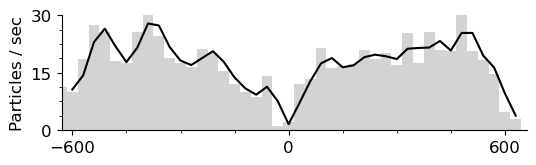

In [25]:
point_count_bbox = [0, img_width, 0, img_height] # [100, img_width-100, 520, 570]

bbox_condition = (keeptrajs_.y >= point_count_bbox[2]) & (keeptrajs_.y < point_count_bbox[3]) & (keeptrajs_.x >= point_count_bbox[0]) & (keeptrajs_.x < point_count_bbox[1])
count, bins = np.histogram(keeptrajs_.loc[bbox_condition,"x"].to_numpy(), bins=np.arange(0, img_width, 40))
count = (count * 1000 / fps) / num_frames
print(max(count))
# NOrmalize counts!

rotifer_cm_x = 890-xmin
bins = (bins - rotifer_cm_x) / mpp
df_counts = pd.DataFrame(np.vstack((bins[:-1], count)).T, columns=["bins", "counts"])

fig, ax = plt.subplots(figsize=(6,1.5))
ax.bar(bins[:-1], count, width=np.diff(bins)[1], color="lightgray")
ax.plot(df_counts.bins, df_counts.counts.rolling(window=2).mean(), "-k", lw=1.5)
ax.set(ylim=(0, max(count)), yticks=np.linspace(0, 30, 3), xlim=(bins[0], bins[-1]), xticks=[-600, 0, 600],#[0,250,500,750]
       xlabel="", ylabel="Particles / sec")
ax.spines[["top","right"]].set_visible(False)
fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-traj-x-coord-histogram_.jpg", **fig_params) if SAVE_FIGURES else None
ax.minorticks_on()
print(keeptrajs_["particle"].nunique())

# make it probability per time?
#> indicates different path lines, maybe ordered somehow for particle retrieval from vortex

In [26]:
df_filt = pd.DataFrame()

for nth in particles:
    traj = keeptrajs_.loc[keeptrajs_["particle"] == nth]
    traj = traj.loc[bbox_condition]
    d = {
        "x" : traj.x.to_list(),
        "y" : traj.y.to_list(),
        "dx" : traj.x.diff().to_list(),
        "dy" : traj.y.diff().to_list()
    }
    df_loop = pd.DataFrame(d)
    df_filt = pd.concat([df_filt, df_loop[1:]])

# XY Velocity at XY coordinates
velocities = df_filt[["dx", "dy"]].to_numpy()

# Velocity per point
df_filt["v_xy"] = np.sqrt(velocities[:, 0] ** 2 + velocities[:, 1] ** 2) * fps / mpp


In [27]:

vortex_trajs = df_filt.copy()
rotifer_cm_x = 890-xmin
vortex_trajs["v_xy"] = np.sqrt(vortex_trajs["dx"] ** 2 + vortex_trajs["dy"] ** 2) * fps / mpp
vortex_trajs[['xnorm', 'ynorm']] = vortex_trajs[['x', 'y']] * fps / mpp
vortex_trajs["xrot_norm"] = vortex_trajs["xnorm"] - rotifer_cm_x / mpp

vortex_trajs.to_csv(f"{save_figure_path}/{vid_filename.split('.')[0]}_horizontal_vortex_trajs.csv", index=False)

In [22]:
#df_filt = pd.read_csv(f"{save_figure_path}/{vid_filename.split('.')[0]}_d_filt.csv")
#df_filt.to_csv(f"{save_figure_path}/{vid_filename.split('.')[0]}_d_filt.csv", index=False)

30.00750187546887


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_51437/1429721011.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filt.groupby('x_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()


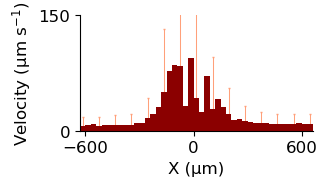

In [23]:
rotifer_cm_x = 890-xmin
bins=np.arange(0, img_width, 40)
bins = (bins - rotifer_cm_x) / mpp

bin_width = 40
print(bin_width / mpp)
bin_edges = np.arange(0, img_width, bin_width) #np.arange(100, img_width-100, bin_width)
df_filt["x_bin"] = pd.cut(df_filt["x"], bins=bin_edges)
grouped = df_filt.groupby('x_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()
medians = grouped.median()
percentile_25 = grouped.quantile(0.25)
percentile_75 = grouped.quantile(0.75)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
bin_centers = (bin_centers - rotifer_cm_x) / mpp


fig, ax = plt.subplots(figsize=(3,1.5))
plt.errorbar(bin_centers, medians, yerr=[medians, percentile_75], fmt='none', ecolor='lightsalmon', elinewidth=.75, errorevery=3, capsize=1, zorder=1)
plt.bar(bin_centers, medians, width=bin_width/mpp, color="darkred", zorder=2)
ax.set(ylim=(0, 150), yticks=[0,150], xlim=(bins[0], bins[-1]), xticks=[-600, 0, 600], # [0,350]
       xlabel="X (µm)", ylabel="Velocity (µm s$^{-1}$)")

ax.spines[["top","right"]].set_visible(False)
#fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-median-velocities-histogram_.jpg", **fig_params) if SAVE_FIGURES else None


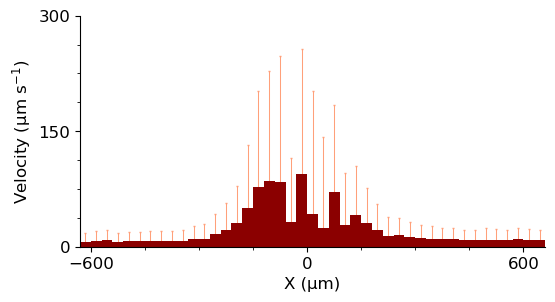

In [24]:
percentile_75 = grouped.quantile(0.75)
percentile_95 = grouped.quantile(0.95)


fig, ax = plt.subplots(figsize=(6,3))
plt.errorbar(bin_centers, medians, yerr=[medians, percentile_75], fmt='none', ecolor='lightsalmon', elinewidth=.75, errorevery=1, capsize=1, zorder=1)
plt.bar(bin_centers, medians, width=bin_width/mpp, color="darkred", zorder=2)
ax.set(ylim=(0, 300), yticks=[0,150,300], xlim=(bins[0], bins[-1]), xticks=[-600, 0, 600], # [0,350]
       xlabel="X (µm)", ylabel="Velocity (µm s$^{-1}$)")

ax.spines[["top","right"]].set_visible(False)
ax.minorticks_on()

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-median-velocities-histogram_binwidth_{bin_width}.jpg", **fig_params)# if SAVE_FIGURES else None


# RADIAL?!

30.00750187546887


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_51437/103515930.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_filt.groupby('x_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()


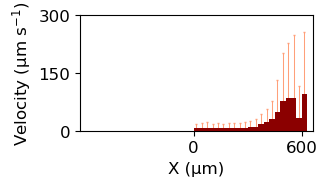

In [25]:
bin_width = 40
print(bin_width / mpp)
bin_edges = np.arange(0, img_width / 2, bin_width) #np.arange(100, img_width-100, bin_width)
df_filt["abs_x"] = df_filt["x"].apply(lambda x: x if x >= 0 else -x)
df_filt["x_bin"] = pd.cut(df_filt["abs_x"], bins=bin_edges)
grouped = df_filt.groupby('x_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()
medians = grouped.median()
percentile_25 = grouped.quantile(0.25)
percentile_75 = grouped.quantile(0.75)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
bin_centers = (bin_centers - 0) / mpp



fig, ax = plt.subplots(figsize=(3,1.5))
plt.errorbar(bin_centers, medians, yerr=[medians, percentile_75], fmt='none', ecolor='lightsalmon', elinewidth=.75, errorevery=1, capsize=1, zorder=1)
plt.bar(bin_centers, medians, width=bin_width/mpp, color="darkred", zorder=2)
ax.set(ylim=(0, 300), yticks=[0,150,300], xlim=(bins[0], bins[-1]), xticks=[600, 0], # [0,350]
       xlabel="X (µm)", ylabel="Velocity (µm s$^{-1}$)");
#ax.invert_xaxis()

In [26]:
bin_centers

array([ 15.00375094,  45.01125281,  75.01875469, 105.02625656,
       135.03375844, 165.04126032, 195.04876219, 225.05626407,
       255.06376594, 285.07126782, 315.07876969, 345.08627157,
       375.09377344, 405.10127532, 435.10877719, 465.11627907,
       495.12378095, 525.13128282, 555.1387847 , 585.14628657,
       615.15378845])

1.117940361554442e-06 1.004583024105899


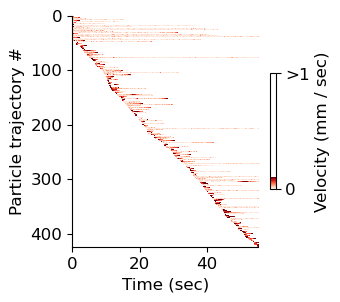

In [27]:
full_frames = np.arange(num_frames)
displacement_array = reindex_calculate_displacement_and_stack(keeptrajs_, full_frames)
displacement_array = (displacement_array / mpp * fps) / 1000
displacement_array[displacement_array==0.0] = np.nan

fr_time = np.arange(num_frames) / fps
print(np.nanmin(displacement_array), np.nanmax(displacement_array))

fig, ax = plt.subplots(1, 1, figsize=(3,3))
cax = ax.imshow(displacement_array, aspect='auto', cmap="Reds", interpolation='none', vmin=0, vmax=.1, extent=[0, fr_time[-1], displacement_array.shape[0], 0])
ax.set(xlabel="Time (sec)", ylabel="Particle trajectory #")
cbar = fig.colorbar(cax, label="Velocity (mm / sec)", shrink=.5); cbar.ax.set(yticks=(0,1), yticklabels=["0", ">1"]);
ax.spines[["top","right"]].set_visible(False)

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-PIV_trajectories-vs-time.jpg", **fig_params) if SAVE_FIGURES else None

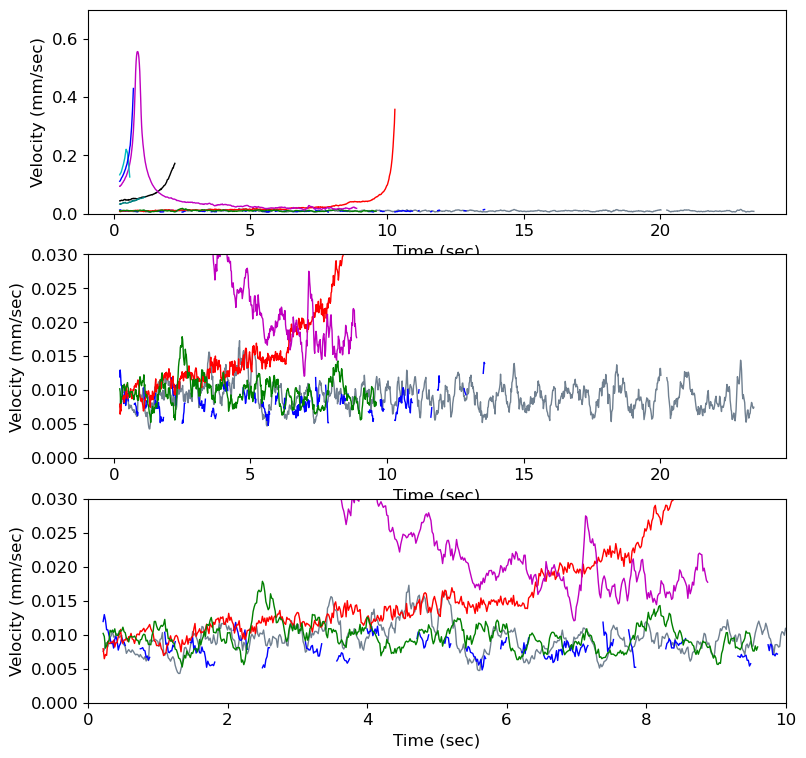

In [28]:
displacement_array = reindex_calculate_displacement_and_stack(keeptrajs_, full_frames)
displacement_array = (displacement_array / mpp * fps) / 1000
df_disp = pd.DataFrame(displacement_array.T)
df_disp = df_disp.replace(0.0, np.nan)

selected_indices = np.arange(8,18)
prt_colors = ["k", "slategrey", "b", "teal", "r", "g", "m", "c", "b"]

rwindow=12
fig, ax = plt.subplots(3,1,figsize=(9,9))
for cax in ax:
    for pc, sidx in zip(prt_colors, selected_indices):
        cax.plot(fr_time, df_disp.iloc[:,sidx].rolling(window=rwindow).mean(), lw=1, color=pc, label=f"prt {sidx}");

xylim = {0 : {"ylim" : (0, .7)},
         1 : {"ylim" : (0, .03)},
         2 : {"ylim" : (0, .03), "xlim" : (0, 10)}}

for nth, cax in enumerate(ax):
    cax.set(xlabel="Time (sec)", ylabel="Velocity (mm/sec)", **xylim[nth])

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-velocity-vs-time_.jpg", **fig_params) if SAVE_FIGURES else None

In [ ]:
# selected_indices2 = ctraj.particle.unique()[selected_indices]

# fig, ax = plt.subplots()
# for pc, sidx in zip(prt_colors, selected_indices2):
#     traj = ctraj.iloc[sidx,:]
#     if not traj.empty:
#         tp.plot_traj(traj, ax=ax, plot_style={"lw" : 1, "alpha" : .6, "color" : pc})

In [417]:
print(dxy.min(), dxy.max())

-20.44262491565331 12.38630471969293


In [156]:
print(dxy.max(), dxy.min())
np.percentile(dxy, [.1, 1, 50, 75, 80, 90, 95])

12.38630471969293 -20.44262491565331


array([-7.82067011e+00, -2.83204142e+00,  4.28068756e-03,  1.45806181e-01,
        1.90176840e-01,  3.38972128e-01,  5.45407821e-01])

# Velocity field calculation

In [92]:

def vorticity_from_velocity(dx, dy, u, v):
    dudy = np.gradient(u, axis=0) / dy
    dvdx = np.gradient(v, axis=1) / dx
    return dvdx - dudy

array([[ 0.        ,  0.        ],
       [-0.72364608, -1.9807738 ],
       [ 0.        ,  0.        ],
       ...,
       [-0.28277804,  0.04595128],
       [ 0.13570617,  0.02394231],
       [-0.09174443,  0.08271008]])

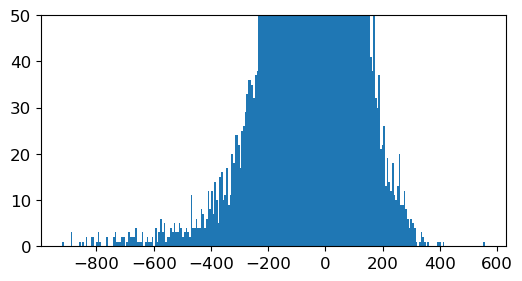

In [419]:
len(list(small_idx))
plt.hist(dxy.flatten() / mpp * fps, bins=250)
plt.ylim(0, 50)

In [427]:
dxy_ = dxy / mpp * fps
#dxy_clipped = np.clip(dxy, -.75, .75)  # clipping high values -.2 and .2
#small_idx = (dxy > -.2) & (dxy < .2) # not normalized
small_idx = (dxy_ > -2) & (dxy_ < 2)
small_idx = np.array(list(map(lambda x, y: x or y, small_idx[:,0], small_idx[:,1])))
#dxy2 = dxy[~small_idx]
#dxy2 = np.clip(dxy2, -1., 1.)

points2 = points[~small_idx,:] / mpp
dxy_2 = dxy_[~small_idx]
dxy_2 = np.clip(dxy_2, -600, 600)

rot_x = (rotifer_bbox[0] + rotifer_bbox[1]) / 2
rot_y = (rotifer_bbox[2] + rotifer_bbox[3]) / 2
print(rot_x, rot_y)
# rot_grid_x = np.where(rot_x > grid_x[0,:])[0][-1] + 1
# rot_grid_y = np.where(rot_y > grid_y[:,0])[0][-1] + 1
# rot_grid_y


822.5 240.0


In [428]:
# Define grid for velocity field
#grid_x, grid_y = np.meshgrid(np.arange(0, img_width, 35), np.arange(0, img_height, 20))  # different or equal bin size ...
grid_x, grid_y = np.meshgrid(np.arange(0, img_width / mpp, 20 / mpp), np.arange(0, img_height / mpp, 20 / mpp))  # different or equal bin size ...
dx = np.diff(grid_x[0, :])[0]
dy = np.diff(grid_y[:, 0])[0]

grid_u = griddata(points2, dxy_2[:, 0], (grid_x, grid_y), method='linear')
grid_v = griddata(points2, dxy_2[:, 1], (grid_x, grid_y), method='linear')

# grid_u = griddata(points, dxy_clipped[:, 0], (grid_x, grid_y), method='linear')
# grid_v = griddata(points, dxy_clipped[:, 1], (grid_x, grid_y), method='linear')

#grid_u = griddata(points, dxy[:, 0], (grid_x, grid_y), method='linear')
#grid_v = griddata(points, dxy[:, 1], (grid_x, grid_y), method='linear')

omega = vorticity_from_velocity(dx, dy, grid_u, grid_v)
print(np.nanmin(omega), np.nanmax(omega), omega.shape, np.percentile(argnotnan(omega.flatten()), [10, 50, 90]))
np.percentile(argnotnan(omega.flatten()), [.01, .1, 1, 10, 50, 90, 99, 99.9, 99.99])
omega_max = np.max([-1 * np.nanmin(omega), np.nanmax(omega)])
print("omega_max", omega_max)

-21.29967042828995 22.985404313580215 (50, 88) [-0.87115216 -0.02241388  0.83972878]
omega_max 22.985404313580215


-9.491326402621086 11.120523277393005 11.0


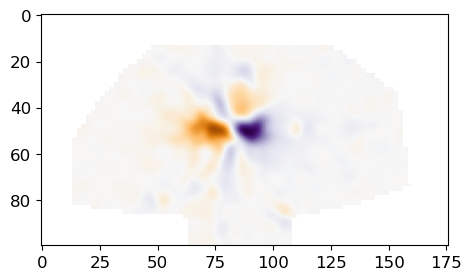

In [432]:
vort_map, _, _ = interpolate_2d_map(omega, grid_x[0,:], grid_y[:,0], scale_factor=2, method='linear', smooth=True, sigma=2)
vort_map_max = np.nanmax(vort_map)
vort_map_min = np.nanmin(vort_map)
vort_map_abs_max = round(np.max([-1*vort_map_min, vort_map_max]), 0) 
print(vort_map_min, vort_map_max, vort_map_abs_max)

plt.figure()
plt.imshow(vort_map, vmin=-vort_map_abs_max ,vmax=vort_map_abs_max, cmap="PuOr", alpha=1)
#plt.plot(rot_grid_x * 2, rot_grid_y * 2, "*k", ms=10, mfc="w")
#plt.plot(len(grid_x[0,:]) - rot_grid_x, len(grid_y[:,0]) - rot_grid_y, "*k", ms=10)

In [433]:
#contour = np.squeeze(get_contours_from_segmasks(["./data/2024_0408_074105_019_frame2063.png"])[0])
#x, y = contour[:,0] / mpp, contour[:,1] / mpp
florence_2_textoutput = [880.3200073242188, 170.10000610351562, 882.239990234375, 167.94000244140625, 884.1599731445312, 166.86000061035156, 886.0799560546875, 166.86000061035156, 888.0, 165.78001403808594, 889.9199829101562, 164.70001220703125, 891.8399658203125, 163.62001037597656, 893.760009765625, 163.62001037597656, 895.6799926757812, 164.70001220703125, 897.5999755859375, 165.78001403808594, 899.5199584960938, 166.86000061035156, 901.4400024414062, 169.02000427246094, 901.4400024414062, 171.1800079345703, 901.4400024414062, 173.3400115966797, 901.4400024414062, 175.5, 899.5199584960938, 177.66000366210938, 899.5199584960938, 179.82000732421875, 897.5999755859375, 181.98001098632812, 897.5999755859375, 184.1400146484375, 897.5999755859375, 186.3000030517578, 895.6799926757812, 189.54000854492188, 895.6799926757812, 192.78001403808594, 895.6799926757812, 196.02000427246094, 893.760009765625, 200.3400115966797, 893.760009765625, 205.74000549316406, 893.760009765625, 208.98001098632812, 893.760009765625, 210.0600128173828, 895.6799926757812, 213.3000030517578, 895.6799926757812, 217.62001037597656, 895.6799926757812, 224.10000610351562, 895.6799926757812, 227.3400115966797, 897.5999755859375, 229.50001525878906, 897.5999755859375, 231.66000366210938, 897.5999755859375, 233.82000732421875, 899.5199584960938, 235.98001098632812, 899.5199584960938, 238.1400146484375, 901.4400024414062, 240.3000030517578, 901.4400024414062, 242.4600067138672, 901.4400024414062, 245.70001220703125, 903.3599853515625, 248.94000244140625, 903.3599853515625, 252.1800079345703, 903.3599853515625, 255.42001342773438, 903.3599853515625, 256.5, 905.2799682617188, 258.6600036621094, 905.2799682617188, 261.9000244140625, 905.2799682617188, 265.1400146484375, 905.2799682617188, 268.3800048828125, 905.2799682617188, 269.46002197265625, 903.3599853515625, 271.6200256347656, 903.3599853515625, 274.8600158691406, 903.3599853515625, 279.1800231933594, 903.3599853515625, 280.260009765625, 901.4400024414062, 283.5, 901.4400024414062, 286.7400207519531, 901.4400024414062, 289.9800109863281, 901.4400024414062, 291.05999755859375, 901.4400024414062, 294.3000183105469, 901.4400024414062, 298.6200256347656, 901.4400024414062, 299.70001220703125, 903.3599853515625, 302.94000244140625, 903.3599853515625, 306.1800231933594, 903.3599853515625, 311.58001708984375, 903.3599853515625, 312.6600036621094, 903.3599853515625, 315.9000244140625, 903.3599853515625, 320.2200012207031, 903.3599853515625, 321.3000183105469, 903.3599853515625, 324.5400085449219, 903.3599853515625, 328.8600158691406, 903.3599853515625, 329.94000244140625, 903.3599853515625, 333.1800231933594, 903.3599853515625, 337.5, 903.3599853515625, 338.58001708984375, 903.3599853515625, 341.82000732421875, 903.3599853515625, 346.1400146484375, 903.3599853515625, 347.2200012207031, 901.4400024414062, 349.3800048828125, 901.4400024414062, 352.6200256347656, 901.4400024414062, 356.94000244140625, 901.4400024414062, 358.02001953125, 901.4400024414062, 361.260009765625, 901.4400024414062, 365.58001708984375, 901.4400024414062, 366.6600036621094, 901.4400024414062, 369.9000244140625, 901.4400024414062, 373.1400146484375, 901.4400024414062, 374.2200012207031, 901.4400024414062, 377.46002197265625, 901.4400024414062, 379.6200256347656, 901.4400024414062, 380.70001220703125, 901.4400024414062, 382.8600158691406, 901.4400024414062, 383.94000244140625, 903.3599853515625, 386.1000061035156, 903.3599853515625, 388.260009765625, 903.3599853515625, 390.4200134277344, 903.3599853515625, 392.58001708984375, 903.3599853515625, 394.7400207519531, 903.3599853515625, 396.9000244140625, 903.3599853515625, 397.9800109863281, 903.3599853515625, 400.1400146484375, 903.3599853515625, 402.3000183105469, 903.3599853515625, 404.46002197265625, 903.3599853515625, 406.6200256347656, 903.3599853515625, 408.780029296875, 903.3599853515625, 410.94000244140625, 901.4400024414062, 413.1000061035156, 901.4400024414062, 415.260009765625, 901.4400024414062, 416.34002685546875, 899.5199584960938, 418.5000305175781, 899.5199584960938, 420.6600036621094, 899.5199584960938, 423.9000244140625, 899.5199584960938, 427.1400146484375, 899.5199584960938, 428.22003173828125, 897.5999755859375, 430.3800048828125, 897.5999755859375, 432.5400085449219, 897.5999755859375, 434.70001220703125, 897.5999755859375, 436.8600158691406, 897.5999755859375, 439.02001953125, 897.5999755859375, 440.1000061035156, 897.5999755859375, 442.260009765625, 897.5999755859375, 444.4200134277344, 897.5999755859375, 446.58001708984375, 897.5999755859375, 447.6600036621094, 897.5999755859375, 449.82000732421875, 897.5999755859375, 451.9800109863281, 897.5999755859375, 453.0600280761719, 897.5999755859375, 455.22003173828125, 897.5999755859375, 457.3800048828125, 897.5999755859375, 459.5400085449219, 897.5999755859375, 461.70001220703125, 897.5999755859375, 463.8600158691406, 895.6799926757812, 466.02001953125, 895.6799926757812, 467.1000061035156, 893.760009765625, 469.260009765625, 893.760009765625, 471.4200134277344, 895.6799926757812, 473.58001708984375, 897.5999755859375, 475.7400207519531, 899.5199584960938, 477.9000244140625, 901.4400024414062, 480.0600280761719, 901.4400024414062, 482.22003173828125, 901.4400024414062, 484.3800048828125, 901.4400024414062, 486.5400085449219, 901.4400024414062, 488.70001220703125, 901.4400024414062, 490.8600158691406, 901.4400024414062, 493.02001953125, 901.4400024414062, 495.1800231933594, 901.4400024414062, 497.34002685546875, 901.4400024414062, 499.5000305175781, 903.3599853515625, 501.6600341796875, 903.3599853515625, 503.82000732421875, 905.2799682617188, 505.9800109863281, 907.199951171875, 508.1400146484375, 907.199951171875, 510.3000183105469, 907.199951171875, 512.4600219726562, 905.2799682617188, 513.5400390625, 903.3599853515625, 514.6199951171875, 901.4400024414062, 515.7000122070312, 899.5199584960938, 515.7000122070312, 897.5999755859375, 516.780029296875, 893.760009765625, 516.780029296875, 891.8399658203125, 515.7000122070312, 889.9199829101562, 515.7000122070312, 888.0, 514.6199951171875, 886.0799560546875, 514.6199951171875, 884.1599731445312, 513.5400390625, 882.239990234375, 512.4600219726562, 880.3200073242188, 511.3800354003906, 878.3999633789062, 510.3000183105469, 876.47998046875, 508.1400146484375, 874.5599975585938, 505.9800109863281, 874.5599975585938, 503.82000732421875, 874.5599975585938, 501.6600341796875, 874.5599975585938, 500.58001708984375, 872.6399536132812, 499.5000305175781, 870.719970703125, 498.4200134277344, 868.7999877929688, 498.4200134277344, 866.8800048828125, 499.5000305175781, 864.9599609375, 499.5000305175781, 863.0399780273438, 500.58001708984375, 861.1199951171875, 501.6600341796875, 859.199951171875, 502.7400207519531, 857.2799682617188, 503.82000732421875, 855.3599853515625, 504.9000244140625, 853.4400024414062, 505.9800109863281, 851.5199584960938, 507.0600280761719, 849.5999755859375, 508.1400146484375, 847.6799926757812, 508.1400146484375, 845.760009765625, 509.22003173828125, 843.8399658203125, 510.3000183105469, 841.9199829101562, 510.3000183105469, 840.0, 511.3800354003906, 838.0799560546875, 511.3800354003906, 836.1599731445312, 512.4600219726562, 834.239990234375, 512.4600219726562, 832.3200073242188, 511.3800354003906, 830.3999633789062, 510.3000183105469, 830.3999633789062, 508.1400146484375, 830.3999633789062, 505.9800109863281, 830.3999633789062, 503.82000732421875, 830.3999633789062, 501.6600341796875, 830.3999633789062, 499.5000305175781, 832.3200073242188, 497.34002685546875, 834.239990234375, 495.1800231933594, 836.1599731445312, 493.02001953125, 836.1599731445312, 490.8600158691406, 836.1599731445312, 488.70001220703125, 836.1599731445312, 486.5400085449219, 836.1599731445312, 484.3800048828125, 838.0799560546875, 482.22003173828125, 838.0799560546875, 480.0600280761719, 838.0799560546875, 477.9000244140625, 840.0, 475.7400207519531, 840.0, 474.6600036621094, 841.9199829101562, 472.5000305175781, 841.9199829101562, 471.4200134277344, 841.9199829101562, 469.260009765625, 843.8399658203125, 467.1000061035156, 843.8399658203125, 464.9400329589844, 843.8399658203125, 462.780029296875, 845.760009765625, 460.6200256347656, 845.760009765625, 458.46002197265625, 845.760009765625, 456.3000183105469, 845.760009765625, 454.1400146484375, 845.760009765625, 453.0600280761719, 845.760009765625, 450.9000244140625, 845.760009765625, 449.82000732421875, 845.760009765625, 447.6600036621094, 845.760009765625, 446.58001708984375, 845.760009765625, 444.4200134277344, 845.760009765625, 443.34002685546875, 845.760009765625, 441.1800231933594, 845.760009765625, 440.1000061035156, 845.760009765625, 437.94000244140625, 845.760009765625, 436.8600158691406, 845.760009765625, 434.70001220703125, 845.760009765625, 432.5400085449219, 845.760009765625, 431.46002197265625, 845.760009765625, 429.3000183105469, 845.760009765625, 428.22003173828125, 845.760009765625, 426.0600280761719, 845.760009765625, 422.82000732421875, 845.760009765625, 420.6600036621094, 845.760009765625, 418.5000305175781, 845.760009765625, 416.34002685546875, 843.8399658203125, 414.1800231933594, 843.8399658203125, 413.1000061035156, 841.9199829101562, 410.94000244140625, 841.9199829101562, 408.780029296875, 841.9199829101562, 406.6200256347656, 841.9199829101562, 405.5400085449219, 841.9199829101562, 403.3800048828125, 840.0, 401.2200012207031, 840.0, 399.0600280761719, 840.0, 394.7400207519531, 840.0, 390.4200134277344, 840.0, 387.1800231933594, 840.0, 385.02001953125, 841.9199829101562, 382.8600158691406, 841.9199829101562, 380.70001220703125, 841.9199829101562, 379.6200256347656, 843.8399658203125, 377.46002197265625, 843.8399658203125, 375.3000183105469, 843.8399658203125, 373.1400146484375, 845.760009765625, 370.9800109863281, 845.760009765625, 368.82000732421875, 845.760009765625, 366.6600036621094, 845.760009765625, 364.5, 845.760009765625, 362.34002685546875, 845.760009765625, 361.260009765625, 845.760009765625, 359.1000061035156, 845.760009765625, 358.02001953125, 845.760009765625, 355.8600158691406, 845.760009765625, 354.780029296875, 845.760009765625, 352.6200256347656, 845.760009765625, 351.5400085449219, 845.760009765625, 350.46002197265625, 845.760009765625, 348.3000183105469, 845.760009765625, 347.2200012207031, 845.760009765625, 345.0600280761719, 845.760009765625, 343.9800109863281, 845.760009765625, 341.82000732421875, 845.760009765625, 340.7400207519531, 845.760009765625, 338.58001708984375, 845.760009765625, 337.5, 845.760009765625, 335.34002685546875, 845.760009765625, 334.260009765625, 845.760009765625, 332.1000061035156, 845.760009765625, 329.94000244140625, 845.760009765625, 328.8600158691406, 845.760009765625, 326.70001220703125, 845.760009765625, 325.6200256347656, 845.760009765625, 323.46002197265625, 845.760009765625, 322.3800048828125, 845.760009765625, 320.2200012207031, 845.760009765625, 319.1400146484375, 845.760009765625, 316.9800109863281, 845.760009765625, 315.9000244140625, 845.760009765625, 313.7400207519531, 845.760009765625, 312.6600036621094, 845.760009765625, 310.5, 845.760009765625, 309.4200134277344, 845.760009765625, 308.34002685546875, 845.760009765625, 306.1800231933594, 845.760009765625, 305.1000061035156, 880.3200073242188, 170.10000610351562]
x, y = florence_2_textoutput[::2], florence_2_textoutput[1::2]
x, y = (np.array(x) / mpp) - xmin/mpp, (np.array(y) / mpp) - ymin/mpp
print(len(x),len(y))

303 303


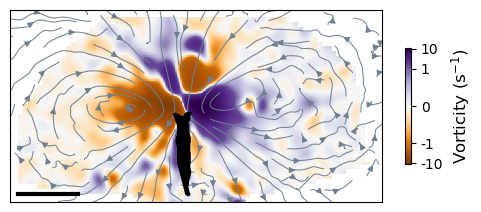

In [435]:
from matplotlib.colors import SymLogNorm
from utils.utils import plot_scalebar

norm = SymLogNorm(linthresh=vort_map_abs_max/ 10, linscale=vort_map_abs_max/5, vmin=-vort_map_abs_max, vmax=vort_map_abs_max)

fig, ax = plt.subplots(figsize=(6,3))
img_show = ax.imshow(vort_map, cmap="PuOr", alpha=1, extent=[0, img_width / mpp, 0, img_height / mpp], norm=norm)
cbar = fig.colorbar(img_show, label="Vorticity (s$^{-1}$)", shrink=.5, ticks=[-10, -1, 0 , 1, 10])#
cbar.set_ticklabels(["-10", "-1", "0", "1", "10"], fontsize=10)

ax.streamplot(grid_x, grid_y, grid_u, grid_v, linewidth=.75, color="slategray", arrowsize=.9, arrowstyle="-|>")

ax.fill_between(x, y, facecolor="k", zorder=5, alpha=1)
#ax.plot(x, y, "-k", zorder=5)

ax.set_xticks([]), ax.set_yticks([])
ax.set_xlim(100/mpp, img_width/mpp-100/mpp), ax.set_ylim(100/mpp, img_height/mpp-100/mpp);
#ax.set(**ax_params);
#set_spines_visible(ax=ax)
ax.set_aspect('equal')#, adjustable='datalim'); 
plot_scalebar(ax=ax, mpp=1/mpp, width_microns=250, position=(100, 100), linewidth=3, fontsize=None)

fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-vorticity.jpg", **fig_params)

410


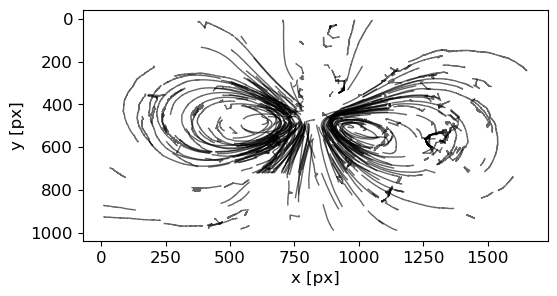

In [380]:
is_continuous = list()
for nth, row in stats.iterrows():
    clist = row["frames_present"]
    if all(np.diff(clist)<=2): #any(np.diff(clist)>=2):
        is_continuous.append(nth)

print(len(is_continuous))

fig, ax = plt.subplots(1,1)
for nth in is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        tp.plot_traj(traj, ax=ax, plot_style={"lw" : 1, "alpha" : .6, "color" : "k"})

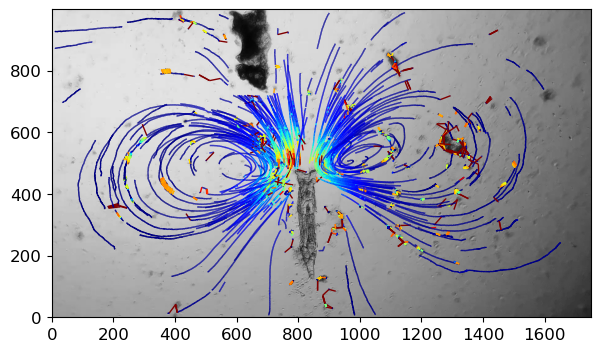

In [381]:
minmax = []
cmap = plt.cm.jet
fig, ax = plt.subplots(figsize=(17,4))
ax.imshow(frames[frame_nr], cmap="gray")
# or only continuous traj, w/o frame jump, or of different diag-size
for nth in is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        x = traj.x.to_numpy()
        y = traj.y.to_numpy()

        dx = traj.x.diff()
        dy = traj.y.diff()
        dist = np.sqrt(dx ** 2 + dy ** 2)

        vector = dist.to_numpy()[1:]
        minmax.append([vector.min(), vector.max()])
        norm = plt.Normalize(0, 20)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=1, alpha=1)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()

#ax.set_xlim(800,1600); ax.set_ylim(0,800)
ax.invert_yaxis()
#fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-displacement.jpg", dpi=600)

### trajectory params

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.particle, stats.ep_median, ".k", alpha=.6)
ax[0].set_ylim(-2.5, 2.5); ax[0].set_xlabel("particle");

ax[1].plot(stats.particle, stats.first_frame, "*r", ms=3, alpha=.6, label="first frame")
ax[1].plot(stats.particle, stats.last_frame, "sk", ms=3, alpha=.6, label="last frame")
ax[1].plot(stats.particle, stats.nframes, "ob", ms=3, alpha=.6, label="number of frames")
ax[1].set_xlabel("particle");
ax[1].legend()

ax[2].hist(stats.travel_dist, bins=150, color="k");
ax[2].set_xlabel("travel distance per particle (pixels)");
ax[2].set_ylabel("Count"); #ax[2].set_xlim(0, 1500);


fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].hist(frames_present / 60, bins=100, density=True, color="k");
ax[0].set_xlabel("frames"); ax[0].set_ylabel("Norm. trajectory particle count");
ax[0].set_ylim(0, .15); #ax[0].set_xlim(0, 1050);


ax[1].hist(stats.nframes, bins=100, color="k");
ax[1].set_xlabel("Number of frames per trajectory")
#ax[1].set_xlim(0, 300);

fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.nframes, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[0].set_xlabel("N frames"); ax[0].set_ylabel("Dist 1st to last frame")

ax[1].plot(stats.nframes, stats.travel_dist, "ko", ms=3, alpha=.6)
ax[1].set_xlabel("N frames"); ax[1].set_ylabel("Path traveled")

ax[2].plot(stats.travel_dist, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[2].set_xlabel("Path traveled"); ax[2].set_ylabel("Dist 1st to last frame");